In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading the data

In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
submission_data = pd.read_csv('gender_submission.csv')

DATA PREPROCESSING

Dropping unnecessary columns

In [4]:
train_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

Filling missing values with the mean age

In [5]:
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)

Encoding categorical variables: Sex and Embarked

In [6]:
train_data['Sex'] = train_data['Sex'].map({'female': 0, 'male': 1})
train_data['Embarked'] = train_data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
test_data['Sex'] = test_data['Sex'].map({'female': 0, 'male': 1})
test_data['Embarked'] = test_data['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

Splitting features and labels

In [7]:
x_train = train_data.drop('Survived', axis=1)
y_train = train_data['Survived']
x_test = test_data

In [8]:
def naive_bayes(x_train, y_train, x_test):
    cp = calculate_class_probabilities(y_train)
    fp = calculate_feature_probabilities(x_train, y_train)
    ans = predict_classes(x_train, y_train, x_test, cp, fp)
    accuracy = calculate_accuracy(ans, submission_data['Survived'])
    print("Naive Bayes Accuracy:", accuracy)
    return ans

def calculate_class_probabilities(y_train):
    class_probabilities = {}
    unique_classes = np.unique(y_train)
    total_instances = len(y_train) + len(unique_classes)
    for cv in unique_classes:
        class_instances = len(y_train[y_train == cv])
        class_probabilities[cv] = (class_instances + 1) / total_instances
    return class_probabilities

def calculate_feature_probabilities(x_train, y_train):
    feature_probabilities = {}
    unique_classes = np.unique(y_train)
    for feature in x_train.columns:
        feature_probabilities[feature] = {}
        for cv in unique_classes:
            feature_probabilities[feature][cv] = calculate_value_probabilities(x_train, y_train, feature, cv)
    return feature_probabilities

def calculate_value_probabilities(x_train, y_train, feature, cv):
    value_probabilities = {}
    unique_values = np.unique(x_train[feature])
    class_instances = len(y_train[y_train == cv])
    for value in unique_values:
        value_instances = len(x_train[(y_train == cv) & (x_train[feature] == value)])
        value_probabilities[value] = (value_instances + 1) / (class_instances + len(unique_values))
    return value_probabilities

def predict_classes(x_train, y_train, x_test, class_probabilities, feature_probabilities):
    predicted_classes = []
    unique_classes = np.unique(y_train)
    for _, instance in x_test.iterrows():
        class_scores = {}
        for cv in unique_classes:
            score = class_probabilities[cv]
            for feature in x_train.columns:
                if instance[feature] in feature_probabilities[feature][cv]:
                    score *= feature_probabilities[feature][cv][instance[feature]]
                else:
                    score *= 1 / (len(y_train[y_train == cv]) + len(np.unique(x_train[feature])))
            class_scores[cv] = score
        predicted_class = max(class_scores, key=class_scores.get)
        predicted_classes.append(predicted_class)
    return predicted_classes

def calculate_accuracy(predicted_classes, actual_classes):
    correct_predictions = np.sum(predicted_classes == actual_classes)
    accuracy = correct_predictions / len(actual_classes)
    return accuracy


K-nearest Neighbour (Making predictions based on majority vote)

In [9]:
def knearestneighbour(x_train, y_train, x_test, k):
    distances = []
    for _, instance in x_test.iterrows():
        instance_distances = []
        for _, train_instance in x_train.iterrows():
            distance = np.linalg.norm(instance - train_instance)
            instance_distances.append(distance)
        distances.append(instance_distances)
    k_nearest = np.argsort(distances)[:, :k]
    predictions = []
    for neighbors in k_nearest:
        neighbor_labels = y_train[neighbors]
        predicted_class = np.bincount(neighbor_labels).argmax()
        predictions.append(predicted_class)
    accuracy = np.sum(predictions == submission_data['Survived']) / len(submission_data)
    print("K-nearest Neighbour Accuracy:", accuracy)
    return predictions

Result

In [10]:
nb_predictions = naive_bayes(x_train, y_train, x_test)
knn_predictions = knearestneighbour(x_train, y_train, x_test, k=5)


Naive Bayes Accuracy: 0.8277511961722488
K-nearest Neighbour Accuracy: 0.6674641148325359


VISUALIZATION

1. Naive Bayes: Scatter Plot of Age vs Fare

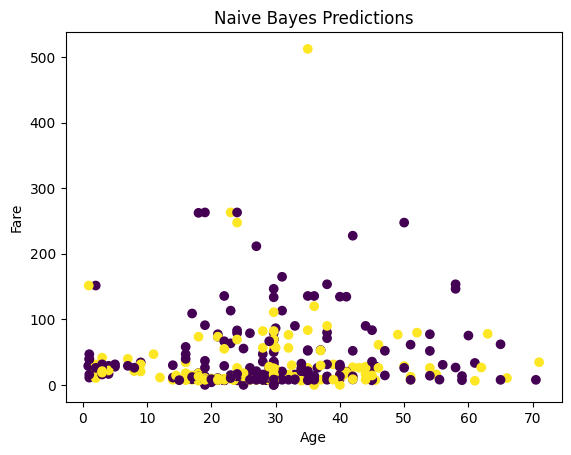

In [11]:
plt.scatter(x_train['Age'][:len(submission_data)], x_train['Fare'][:len(submission_data)], c=nb_predictions)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Naive Bayes Predictions')
plt.show()

2. K-Nearest Neighbour: Scatter Plot of Age vs Fare

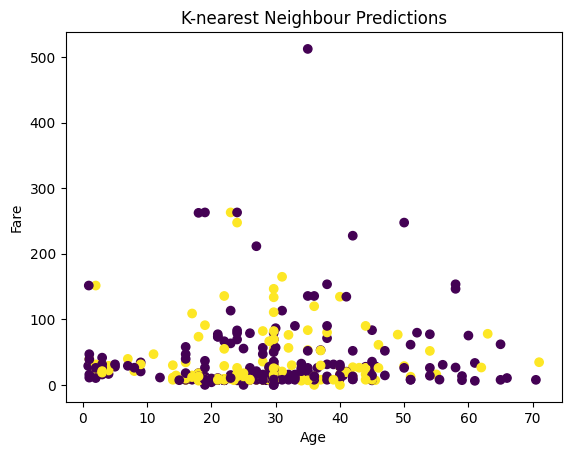

In [12]:
plt.scatter(x_train['Age'][:len(submission_data)], x_train['Fare'][:len(submission_data)], c=knn_predictions)
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('K-nearest Neighbour Predictions')
plt.show()

Bar Plot of Survival Counts by Passenger Class

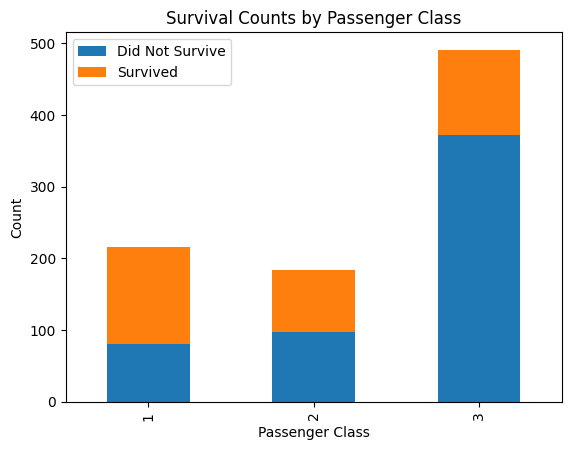

In [13]:
class_survival = train_data.groupby(['Pclass', 'Survived']).size().unstack()
class_survival.plot(kind='bar', stacked=True)
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.title('Survival Counts by Passenger Class')
plt.legend(['Did Not Survive', 'Survived'])
plt.show()

Histogram of Passenger Age Distribution

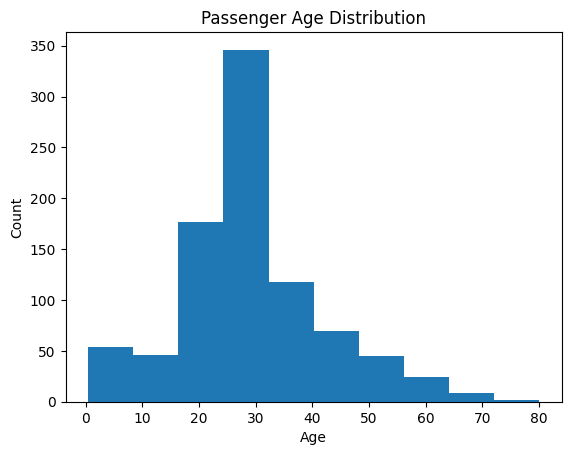

In [14]:
plt.hist(train_data['Age'], bins=10)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Passenger Age Distribution')
plt.show()